# Similarities Check within Traffic Categories

In this notebook, we leverage the **Jensen Shannon** distance to find similarities between traffic distributions.

Add the needed imports.

In [1]:
%reload_ext autoreload
%autoreload 2
import threadpoolctl

from itertools import combinations
import matplotlib as mpl
from intellect.dataset import portions_from_data
from intellect.distance import distributions_to_probabilities
from intellect.io import create_dir
import pandas as pd

from scipy.spatial.distance import jensenshannon

mpl.rcParams['figure.dpi']= 70
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
threadpoolctl.threadpool_limits(limits=2);

And parameters.

In [2]:
DATASET = "./dataset_shrinked.h5"
OUTPUT_DIR = "correlations_output/"
BENIGN_LABELS = ["BENIGN"]

Load the dataset as a single portion and create the output directory.

In [3]:
ds = portions_from_data(DATASET, normalize=True, benign_labels=BENIGN_LABELS, ratios=(1,))[0]

In [22]:
create_dir(OUTPUT_DIR)

Show the traffic distribution with the a pie chart.

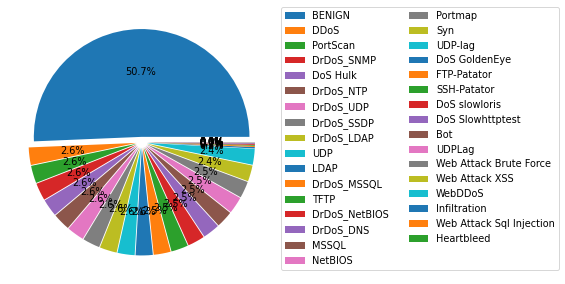

In [4]:
v = ds._y.value_counts()
v_perc = {k: f"{k} ({v})" for k,v in (ds._y.value_counts(normalize=True) * 100).round(2).items()}
ax = v.plot.pie(legend=True, ylabel="", explode=(0.05,)*len(v), labeldistance=None, autopct='%1.1f%%', figsize=(20,5))
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', ncol=2);

Clearly, it shows that the Benign and Malicious samples are balanced, but within the Malicious traffic there are many classes with just few samples, such as for *Heartbleed*.

For each combination of traffic category and for each feature column compute Jensen Shannon distance.

In [ ]:
ret = {}
for x,y in combinations(ds.categories, 2):
    c,d = ds.filter_categories([x]), ds.filter_categories([y])
    out = {}
    print((x,y), end=" - ")
    for col in c.X.columns.values:
        print(col, end=", ")
        _, v1, v2 = distributions_to_probabilities(c.X[col].to_numpy(), d.X[col].to_numpy(), only_common=False)
        out[col] = jensenshannon(v1, v2)
    ret[(x,y)] = out
    print("Finished")
pd.DataFrame(ret.values(), index=ret.keys()).to_csv(OUTPUT_DIR + "jensenshannon_perfeature.csv")

In [ ]:
result = pd.read_csv(OUTPUT_DIR + "jensenshannon_perfeature.csv", index_col=[0,1])
#result.T.describe()

Find those pairs with highest and lowest mean of the JS distance among all features.

In [9]:
m = result.T.describe().loc["mean"]
most_similar = m[m < 0.5]
most_different = m[m >= 0.5]

Identify the closest.

In [11]:
next(k for k in most_similar.sort_values(ascending=True).keys().values if "BENIGN" in k[0] or "BENIGN" in k[1])

('BENIGN', 'UDPLag')

Identify the furthest, ignoring all those with small samples (first initial rows).

In [ ]:
it = (k for k in most_different.sort_values(ascending=False).keys().values if "BENIGN" in k[0] or "BENIGN" in k[1])
list(it)

In [13]:
chosen_close = (('BENIGN', 'UDPLag'))
chosen_far = ('DDoS', 'BENIGN')

In [14]:
result.loc[[chosen_close, chosen_far]].T.describe()

,BENIGN,DDoS
,UDPLag,BENIGN
count,64.000000,64.000000
mean,0.465976,0.545040
std,0.241393,0.249403
min,0.006920,0.006920
25%,0.242897,0.410290
50%,0.483282,0.651701
75%,0.617308,0.740625
max,0.805858,0.832239
